<a href="https://colab.research.google.com/github/Dyl-cmyk/datascience/blob/projects/DylaLaurUnit6Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 6 Project: Making a Generalized Linear Model (multiple predictors)

Formula 1 is an incredibly complicated sport, with so much strategy, car design, and personal preference every team uses dozens of race engineers to take in mounds and mounds of data optimize the performance of the cars and the drivers.

With this idea of so much going into the ultimate goal of all races, to finish in 1st place, I decided to see if bambi could tell me the relatonship between Position and the Lap time required to obtain the best place possible. In addtion I asked it to factor in other relvant information such as the tire compound, team the car was owned by, and driver driving the car.

**Note:** My original goal was to try and find out of being in a lower position on the grid limited your fastest possible lap time, BUT the code and MR.A both agreed that this was not really a meaningful analysis and decided to break (see attempt 1). So, I switched to see what laptime was needed to succeffully gain a position on the Formula 1 Grid.

###Clutter


In [ ]:
!pip install git+https://github.com/pydata/xarray.git

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-vzn1er2w
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-vzn1er2w
  Resolved https://github.com/pydata/xarray.git to commit c25215299c02cd36781cf3aa38e8583d1fe14849
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for xarray: filename=xarray-2025.1.3.dev1+gc2521529-py3-none-any.whl size=1247984 sha256=ad768bdb9c5648048313bae26c36fcb6d9586b173b2062b8701b4f074c53e9ad
  Stored in directory: /tmp/pip-ephem-wheel-cache-8si52c78/wheels/15/f9/46/ac58ec95d7761bd0b92f54d99c5d132719866f63745c3702ed
Successfully built xarray
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.1.1
    Uninstalling xarray-2025.1.1:
      Successfully uninstalled xarray-2025.1.1


In [ ]:
!pip install bambi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 1.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import xarray as xr
import bambi as bmb

In [ ]:
USGP24= pd.read_csv('https://raw.githubusercontent.com/Dyl-cmyk/datascience/refs/heads/main/Unit%206%20Project%20Data%20-%20Sheet1%20(1).csv')

In [ ]:
USGP24

,Driver,Team,LT,Tires,Pit,Lap,Position
0,Norris,McLaren,1:42.902,Medium,No,1,4
1,Norris,McLaren,1:40.864,Medium,No,2,4
2,Norris,McLaren,2:04.410,Medium,No,3,4
3,Norris,McLaren,2:30.670,Medium,No,4,4
4,Norris,McLaren,2:45.769,Medium,No,5,4
...,...,...,...,...,...,...,...
1052,Russel,Mercedes,1:38.608,Medium,No,52,7
1053,Russel,Mercedes,1:39.888,Medium,No,53,7
1054,Russel,Mercedes,1:38.724,Medium,No,54,7
1055,Russel,Mercedes,1:38.180,Medium,No,55,6


###Attempt 1 bambi auto generated 1 vs multi perdictors


This code created a lot of problems for me. Unfortunately bambi is just as dumb at recgonizing quantative varibles as it is smart sometimes. So, I had tried to get it to "get dummies", but it wasnt having that so I gave up on trying to perdict lap time.

In [ ]:
USGP24 = pd.get_dummies(USGP24, columns=["Pit"])

In [ ]:
#USGPSINGLE= US Grand Prix Single Perdictor
model_USGPSINGLE_bmb = bmb.Model("LT ~ Position", USGP24, family = "gaussian")

In [ ]:
idata_USGPSINGLE_bmb = model_USGPSINGLE_bmb.fit(idata_kwargs={"log_likelihood":True})

ValueError: Incompatible Elemwise input shapes [(1057, 982), (1, 1057)]

Sooooo it seems that Lap time cannot be solely perdicted by position because a categorical varible cannot be the only perdictor of a quantative varible.

Becuase of this i am going to give up on single perdictors and try mutli

###Attempt 2 Bmbi with all the perdictors flowing into Position

After a lot of finagleing I realzed that im just going to have to switch position and lap time. This seems to work like a charm! So on we go!

In [ ]:
USGP24= pd.read_csv('https://raw.githubusercontent.com/Dyl-cmyk/datascience/refs/heads/main/Unit%206%20Project%20Data%20-%20Sheet1%20(1).csv')
#switching the varibles back from the "get dummies" code

In [19]:
#Now with multiple perdictors
model_USGPALL_bmb = bmb.Model("Position ~ Driver + Tires + LT + Team", USGP24)
idata_USGPALL_bmb = model_USGPALL_bmb.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


After an hour and a half....its done

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


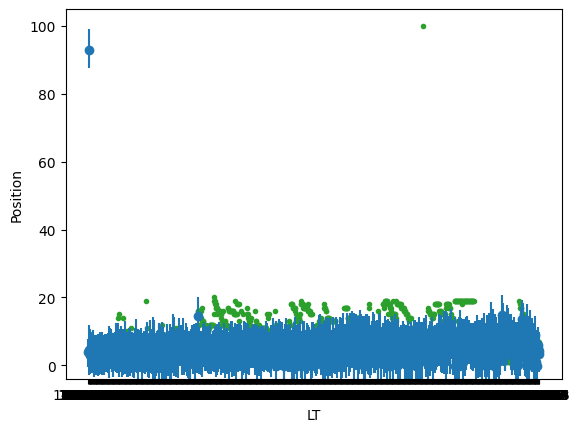

In [20]:
#lets see how this fits vs the data
bmb.interpret.plot_predictions(model_USGPALL_bmb, idata_USGPALL_bmb, "LT", pps=True)
plt.plot(USGP24.LT, USGP24.Position, "C2.", zorder=-3)

<Axes: xlabel='Position'>

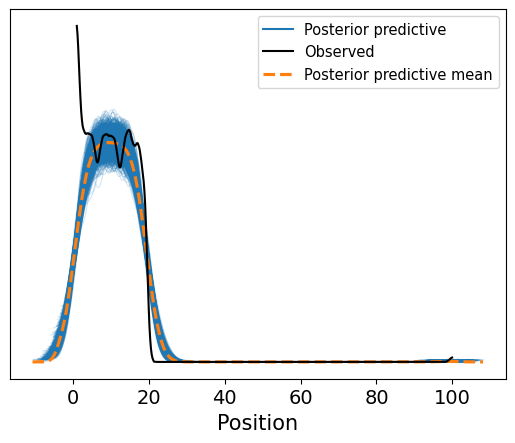

In [21]:
model_USGPALL_bmb.predict(idata_USGPALL_bmb, kind="response")
az.plot_ppc(idata_USGPALL_bmb)

Fit seems eh, well see how everything else compares

I also decided to re-run the single Laptime Into Position perdictor

In [ ]:
#lets try this again
model_USGPLT_bmb = bmb.Model("Position ~ LT", USGP24)
idata_USGPLT_bmb = model_USGPLT_bmb.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


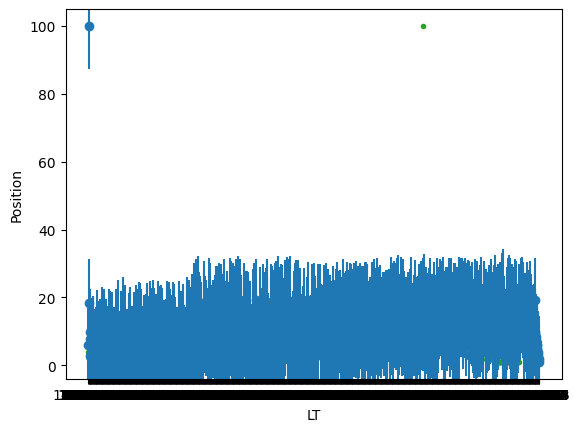

In [ ]:
#might as well see how this fits also
bmb.interpret.plot_predictions(model_USGPLT_bmb, idata_USGPLT_bmb, "LT", pps=True)
plt.plot(USGP24.LT, USGP24.Position, "C2.", zorder=-3)

Welllll this was not what i expected this graph to look like but I guess this is what happens when you have this many points...I don't now if this is bambi saying it doesnt know how to interpret this information, but ill try to interpret it as best as I can. Lets look at the old school PPC and comparisons first

<Axes: xlabel='Position'>

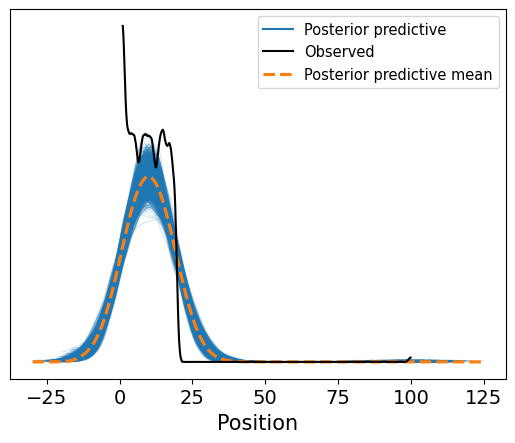

In [ ]:
model_USGPLT_bmb.predict(idata_USGPLT_bmb, kind="response")
az.plot_ppc(idata_USGPLT_bmb)

So, this PPC looks horrible. I can already tell you that this is NOT the best way to go about perdicting this

####Comparison

Lets take a look at these two and figure out if simpler is going to be better

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

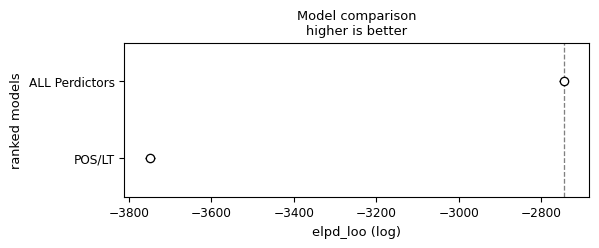

In [23]:
#cmp_df stands for compare dataframe
cmp_df1 = az.compare( {"ALL Perdictors":idata_USGPALL_bmb,"POS/LT":idata_USGPLT_bmb} )

#0 is the best rank; we want a lower elpd_loo
cmp_df1
az.plot_compare(cmp_df1)

In [24]:
cmp_df_bmb = az.compare( {"All Perdictors":idata_USGPALL_bmb,"POS/LT":idata_USGPLT_bmb} )
cmp_df_bmb

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
All Perdictors,0,-2745.402417,788.689845,0.000000,1.0,10.529365,0.000000,True,log
POS/LT,1,-3748.606754,770.358615,1003.204337,0.0,11.093425,14.922313,True,log


Unsuprisingly, All of the perdictors is clearly better. By like. A lot. So im going to try a little bit to see if theres a better way to do this, but im feeling like there isnt.

###Attempt 3 Removing Team

I have chosen to remove team here because Team determies lap time, so this simplifies this code a little more(I may set this up as a hirerarchy later)

In [25]:
model_USGPNTE_bmb = bmb.Model("Position ~ Driver + Tires + LT", USGP24)
idata_USGPNTE_bmb = model_USGPNTE_bmb.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


The simplified code is relfected in the run time

Lets look at the comparison

In [26]:
cmp_df_bmbATT3 = az.compare( {"All Minus Team":idata_USGPNTE_bmb,"ALL Perdictores":idata_USGPALL_bmb} )
cmp_df_bmbATT3

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
All Minus Team,0,-2716.431641,774.693341,0.000000,0.86211,9.916412,0.000000,True,log
ALL Perdictores,1,-2745.402417,788.689845,28.970776,0.13789,10.529365,9.039254,True,log


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

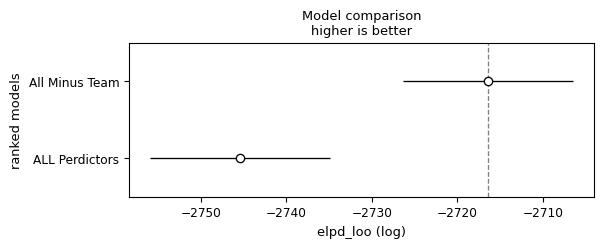

In [27]:
#cmp_df stands for compare dataframe
cmp_df3 = az.compare( {"ALL Perdictors":idata_USGPALL_bmb,"All Minus Team":idata_USGPNTE_bmb} )

#0 is the best rank; we want a lower elpd_loo
cmp_df3
az.plot_compare(cmp_df3)

I KNEW IT! I KNEW REMOVING TEAM WAS A GOOD IDEA



Unfourtinatley I am out of time. The cleaning of my data and length of run time on the "all" has taken up all the time I had for this project.
The thing I have learned is that less can be more, and also reason can get you VERY far when trying to decide what should be kept and not. Sometimes this reason involves ddrawing a causual diagram.